# **Backend de proyecto analizador de PIP.**

> *Se debe reproducir las celdas de forma secuencial para la ejecucion de codigo aguas abajo.



## **Bloque de modulos**

In [2]:
#Carga de librerias de interes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **Bloque conceptual, se utiliza un ejemplo numerico, que sigue el diagrama de flujo algoritmico, sirve como referente NO GRAFICO**

In [101]:
import numpy as np
import pandas as pd

# --- Configuración ---
#np.random.seed(42)  # Para reproducibilidad
n_velas = 200       # Más velas para mayor contexto
window = 50
volatility = 0.0010  # Mayor volatilidad (ajustar según necesidad)
min_cuerpo_pips = 5  # Reducir el mínimo de pips para el cuerpo de la vela

# --- 1. Generar Datos Sintéticos con Tendencias Fuertes ---
def generar_datos_sinteticos(n_velas, start_price=1.1000, volatility=0.0010):
    closes = start_price + np.cumsum(np.random.normal(loc=0.0002, scale=volatility, size=n_velas))  # Tendencias más marcadas
    opens = np.roll(closes, shift=1)
    opens[0] = start_price
    highs = closes + np.abs(np.random.normal(loc=0.0003, scale=0.0002, size=n_velas))  # Máximos más altos
    lows = closes - np.abs(np.random.normal(loc=0.0003, scale=0.0002, size=n_velas))   # Mínimos más bajos
    return pd.DataFrame({'open': opens, 'high': highs, 'low': lows, 'close': closes})

df = generar_datos_sinteticos(n_velas)

# --- 2. Calcular Soporte/Resistencia ---
df['soporte'] = df['low'].rolling(window=window).min()
df['resistencia'] = df['high'].rolling(window=window).max()

# --- 3. Buscar Rupturas en Todas las Velas ---
operaciones = []
for i in range(window, len(df)):
    vela = df.iloc[i]
    resistencia = df['resistencia'].iloc[i-1]
    soporte = df['soporte'].iloc[i-1]
    rango_pips = (resistencia - soporte) * 10000
    cuerpo_vela = abs(vela['close'] - vela['open']) * 10000

    if (vela['close'] > resistencia) and (cuerpo_vela >= min_cuerpo_pips):
        entrada = vela['close']
        sl = entrada - (rango_pips * 0.5) / 10000
        tp = entrada + (rango_pips * 1.0) / 10000
        operaciones.append(('COMPRA', i, entrada, sl, tp, f"Rango: {rango_pips:.0f} pips"))

    elif (vela['close'] < soporte) and (cuerpo_vela >= min_cuerpo_pips):
        entrada = vela['close']
        sl = entrada + (rango_pips * 0.5) / 10000
        tp = entrada - (rango_pips * 1.0) / 10000
        operaciones.append(('VENTA', i, entrada, sl, tp, f"Rango: {rango_pips:.0f} pips"))

# --- 4. Resultados ---
if operaciones:
    print(f"\nSeñales generadas ({len(operaciones)}):")
    for op in operaciones[-5:]:  # Mostrar las últimas 5 señales
        print(f"- {op[0]} en vela {op[1]}: Entrada = {op[2]:.4f}, SL = {op[3]:.4f}, TP = {op[4]:.4f} | {op[5]}")
else:
    print("\nNo se encontraron señales. Ajusta los parámetros (volatilidad, tamaño de cuerpo, etc.).")


Señales generadas (22):
- COMPRA en vela 143: Entrada = 1.1351, SL = 1.1289, TP = 1.1477 | Rango: 125 pips
- COMPRA en vela 144: Entrada = 1.1363, SL = 1.1295, TP = 1.1498 | Rango: 135 pips
- COMPRA en vela 186: Entrada = 1.1377, SL = 1.1330, TP = 1.1470 | Rango: 93 pips
- COMPRA en vela 187: Entrada = 1.1394, SL = 1.1341, TP = 1.1501 | Rango: 107 pips
- COMPRA en vela 192: Entrada = 1.1415, SL = 1.1352, TP = 1.1540 | Rango: 125 pips


## **Bloque de generacion de datos sinteticos** (EN TESTING)

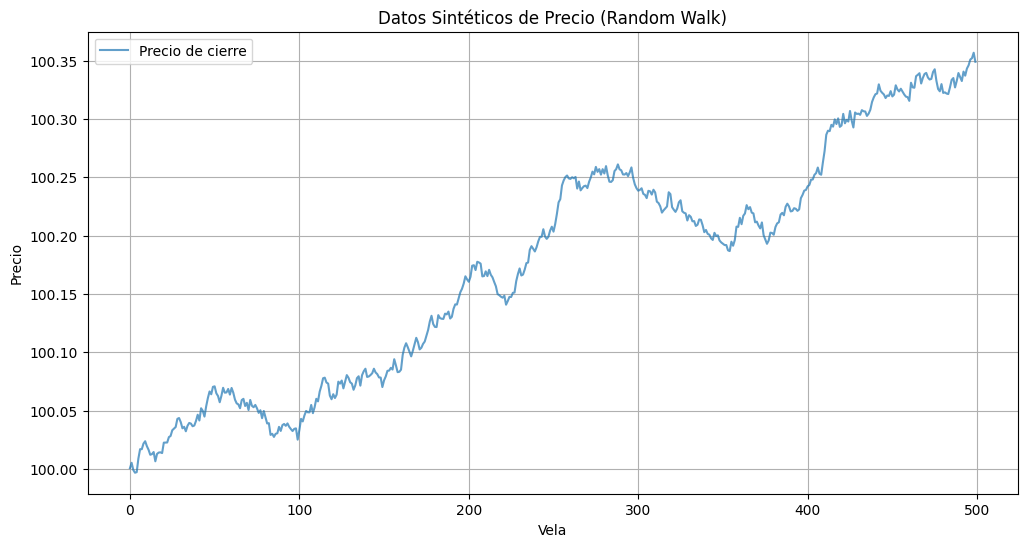

In [13]:
# Configuración
np.random.seed(2025)  # Para reproducibilidad
n_velas = 500       # Número total de velas
window = 50         # Ventana para soporte/resistencia (50 pips/velas)

# Generar datos sintéticos (random walk con tendencia)
returns = np.random.normal(loc=0.001, scale=0.005, size=n_velas) #Se usa una distribucion normal
precio = 100 + np.cumsum(returns)  # Precio inicial = 100

# Crear DataFrame
df = pd.DataFrame(precio, columns=['close'])
df['high'] = df['close'] + np.random.uniform(0.1, 0.3, size=n_velas)  # Máximos de velas
df['low'] = df['close'] - np.random.uniform(0.1, 0.3, size=n_velas)   # Mínimos de velas

# Parametros de visualizacion
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Precio de cierre', alpha=0.7)
plt.title('Datos Sintéticos de Precio (Random Walk)')
plt.xlabel('Vela')
plt.ylabel('Precio')
plt.legend()
plt.grid()
plt.show()

## **Bloque de analisis, usando estrategia "BIAS 50"** (EN TESTING)

In [14]:
#Calculo de soportes (Pmin) y resistencias (Pmax)
def calcular_soporte_resistencia(df, window=50):
    """Encuentra soporte (mínimo) y resistencia (máximo) en la ventana."""
    df['soporte'] = df['low'].rolling(window=window).min()
    df['resistencia'] = df['high'].rolling(window=window).max()
    return df

def detectar_ruptura(df, i, min_body=0.5):
    """
    Detecta ruptura con 'fuerza':
    - Cuerpo de vela > min_body (ej. 0.5 pips).
    - Precio cierra fuera de soporte/resistencia.
    """
    vela = df.iloc[i]
    precio_cierre = vela['close']
    precio_open = vela['close'] - np.random.uniform(-0.2, 0.2)  # Simular apertura

    # Fuerza: cuerpo grande y ruptura
    cuerpo = abs(precio_cierre - precio_open)
    ruptura_compra = (precio_cierre > vela['resistencia']) and (cuerpo > min_body)
    ruptura_venta = (precio_cierre < vela['soporte']) and (cuerpo > min_body)

    return ruptura_compra, ruptura_venta

def simular_estrategia(df, window=50, ratio_risk_reward=2):
    """Simula entradas, SL y TP basados en la estrategia."""
    df = calcular_soporte_resistencia(df, window)
    operaciones = []

    for i in range(window, len(df)):
        ruptura_compra, ruptura_venta = detectar_ruptura(df, i)
        vela = df.iloc[i]

        if ruptura_compra:
            # Entrada en compra
            entrada = vela['close']
            sl = vela['soporte']  # SL en el soporte reciente
            tp = entrada + (entrada - sl) * ratio_risk_reward  # TP 1:2
            operaciones.append(('compra', i, entrada, sl, tp))

        elif ruptura_venta:
            # Entrada en venta
            entrada = vela['close']
            sl = vela['resistencia']  # SL en la resistencia reciente
            tp = entrada - (sl - entrada) * ratio_risk_reward  # TP 1:2
            operaciones.append(('venta', i, entrada, sl, tp))

    return pd.DataFrame(operaciones, columns=['tipo', 'indice', 'entrada', 'sl', 'tp'])

# Aplicar estrategia
df_operaciones = simular_estrategia(df)
print(df_operaciones.head())  # No muestra operaciones, sirve para alimentar VISUALIZACION

Empty DataFrame
Columns: [tipo, indice, entrada, sl, tp]
Index: []


## **Bloque de visualizacion de resultados** (EN TESTING)

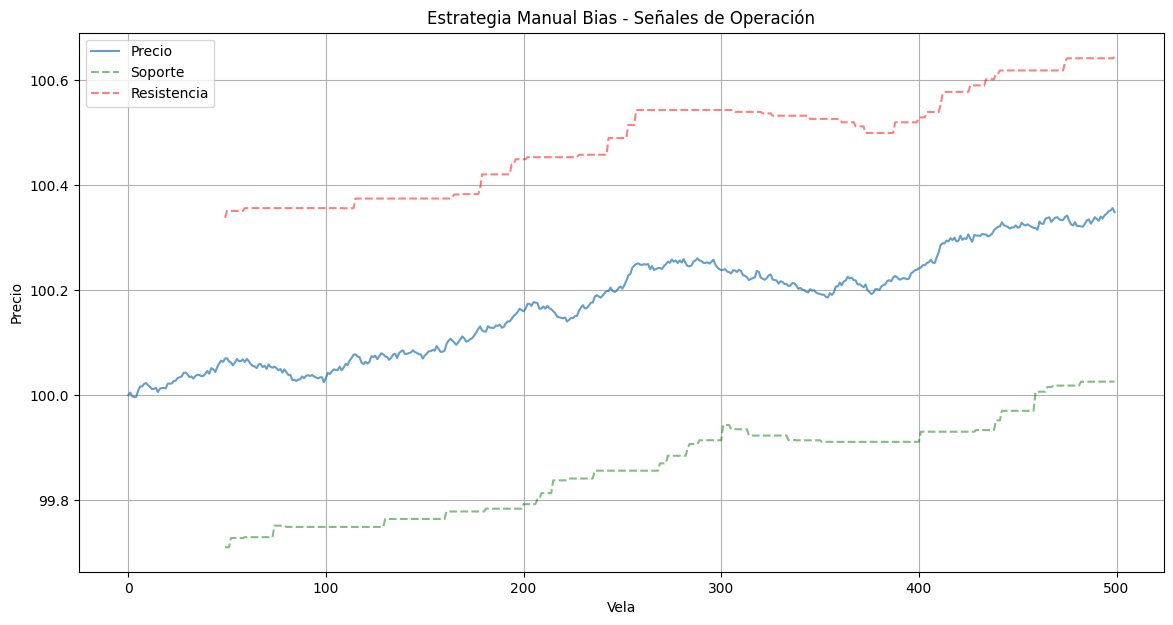

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(df['close'], label='Precio', alpha=0.7)
plt.plot(df['soporte'], 'g--', label='Soporte', alpha=0.5)
plt.plot(df['resistencia'], 'r--', label='Resistencia', alpha=0.5)

# Marcadores de operaciones
for _, op in df_operaciones.iterrows():
    color = 'blue' if op['tipo'] == 'compra' else 'red'
    plt.scatter(op['indice'], op['entrada'], color=color, s=100, marker='^' if op['tipo'] == 'compra' else 'v')
    plt.plot([op['indice'], op['indice']], [op['entrada'], op['sl']], color=color, linestyle=':', alpha=0.5)
    plt.plot([op['indice'], op['indice']], [op['entrada'], op['tp']], color=color, linestyle='-', alpha=0.5)

plt.title('Estrategia Manual Bias - Señales de Operación')
plt.xlabel('Vela')
plt.ylabel('Precio')
plt.legend()
plt.grid()
plt.show()